In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from math import *
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
from FullPackPrediction import *

In [3]:
def plot_double(pred,true,roll_days=30):
    
    mae=np.abs(true-pred).shift(1).rolling(roll_days).mean().dropna()
    with plt.style.context('seaborn-white'):
        font = {'family': 'normal','weight': 'bold'}
        matplotlib.rc('font', **font)
        plt.figure(figsize=(17, 12))
        plt.subplots_adjust(wspace=0, hspace=0.4)
        gs = gridspec.GridSpec(5, 1)
        ax1 = plt.subplot(gs[:2, :])
        ax2 = plt.subplot(gs[2, :], sharex=ax1) 
        ax1.plot(pred/1e3, label='Prediction ')
        ax1.plot(true/1e3, label='Actual', color='r')
        ax2.plot(mae, color='#443f3e', label='MAE')
        ax2.set_title('MAE скользящее за {} дней '.format(roll_days),fontweight="bold")
        ax1.set_ylabel('тысяч рублей')

        ax1.legend()
        ax2.legend()
        ax1.grid(True)
        ax2.grid(True)
        plt.show()

### Загрузка необходимых данных 
Загружаем истрию снятий, информацию о времени доступности банкоматов и месте размещения.

In [4]:
# Если не поменять название целевой переменной на CLIENT_OUT, то Vanga может упасть
target_col = 'CLIENT_OUT'

# Читаем историю снятий
smsb = pd.read_csv('./data/lecture2/atm_data_train.csv', index_col=[0], parse_dates=True).rename(columns = {'Клиентский расход' : target_col})
smsb.head()

,ATM_ID,Входящий остаток,CLIENT_OUT
2015-01-01,869273,6782200.0,0.0
2015-01-01,785116,8104000.0,0.0
2015-01-01,786314,11700600.0,274800.0
2015-01-01,786676,9891200.0,0.0
2015-01-01,791711,4698800.0,10000.0


Информация о времени доступности.

In [5]:
df_availability = pd.read_csv('./data/lecture2/df_availability.csv', index_col = 0)
df_availability.head()

,name_opti,CASHP_ID,1,2,3,4,5,6,7,24 h
ATM_ID,,,,,,,,,,
35426,ATM35426,ATM03062,1,1,1,1,1,0,0,0.0
36008,ATM36008,ATM03053,1,1,1,1,1,1,1,0.0
36009,ATM36009,ATM03017,1,1,1,1,1,0,0,0.0
36010,ATM36010,ATM03063,1,1,1,1,1,0,0,0.0
36413,ATM36413,ATM03100,1,1,1,1,1,1,1,0.0


Кластеризация банкоматов по типу размещения.

In [6]:
df_places = pd.read_csv('./data/lecture2/places.csv', index_col = 0)
df_places.head()

,ATM_ID,cluster
0,34074,0
1,34084,0
2,34100,0
3,34401,0
4,34724,2


Далее идет расшифровка номеров кластеров.

In [7]:
clusters = pd.read_csv('./data/lecture2/clusters.csv', index_col = 'cluster_number')
clusters

,cluster_name
cluster_number,
0,bank
1,small_shop
2,big_shop
3,transport
4,hospital
5,metro
6,park
7,culture
8,education_building


Информация о простоях банкоматов: для каждого банкомата известен процент времени, в течении которого банкомат по техническим причинам не выдавал деньги. В колонке downtime указан доля от времени доступности, в течение которого банкомат простаивал. То есть, например, если банкомат доступен с 10 до 18 часов (какой-нибудь магазин), и был отключен с 10 до 14, то доля простоя - 0.5.

In [8]:
downtime = pd.read_csv('./data/lecture2/downtimes_opt.csv', index_col = 'Unnamed: 0', parse_dates = True)
downtime.head()

,ATM_ID,downtime
2015-01-01,869273,0.0
2015-01-02,869273,0.0
2015-01-03,869273,0.0
2015-01-04,869273,0.0
2015-01-05,869273,0.0


In [9]:
downtime

,ATM_ID,downtime
2015-01-01,869273,0.0
2015-01-02,869273,0.0
2015-01-03,869273,0.0
2015-01-04,869273,0.0
2015-01-05,869273,0.0
...,...,...
2017-09-13,381600,0.0
2017-09-14,381600,0.0
2017-09-15,381600,0.0
2017-09-16,381600,0.0


Загрузка информации о производственном календаре.

In [10]:
events = pd.read_csv('./data/lecture2/events.csv', index_col=0, parse_dates=True)
events.head()

,выходной,праздник,короткий рабочий день,предпраздничный рабочий день,предвыходной рабочий день,последний день месяца,пн,вт,ср,чт,...,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек,предвыходной
2009-01-01,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-02,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-03,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-04,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2009-01-05,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0


Посмотрим на банкомат с простоями.

In [11]:
play=smsb[smsb.ATM_ID==370222]['CLIENT_OUT']

In [12]:
smsb.head()

,ATM_ID,Входящий остаток,CLIENT_OUT
2015-01-01,869273,6782200.0,0.0
2015-01-01,785116,8104000.0,0.0
2015-01-01,786314,11700600.0,274800.0
2015-01-01,786676,9891200.0,0.0
2015-01-01,791711,4698800.0,10000.0


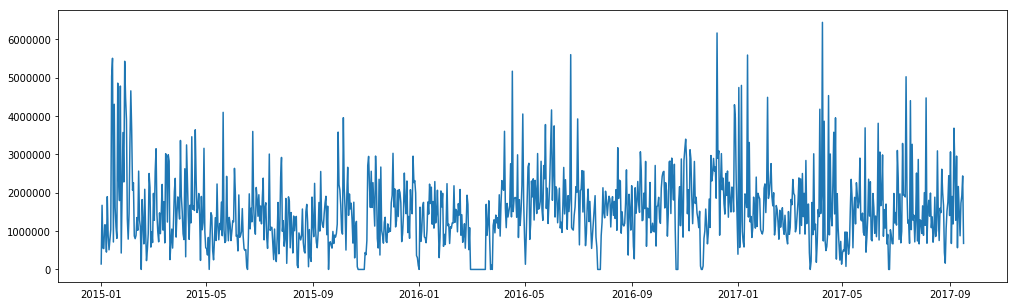

In [13]:
plt.figure(figsize=(17,5))
plt.plot(play)
plt.show()

Ниже приведены даты - начало и конец очередного простоя.

In [14]:
changer = Changer(ID=None,timeseries=None, timeseries_downtime=None, pool=None)
play_downtime=changer.detect_downtimes(downtime[downtime.ATM_ID == 370222]['downtime'],3)
play_downtime

,downtime_begin,downtime_end
0,2015-06-17,2015-06-19
1,2015-08-22,2015-08-24
2,2015-10-22,2015-11-02
3,2016-02-27,2016-03-28
4,2016-07-23,2016-07-25
5,2016-11-21,2016-11-23
6,2017-05-02,2017-05-05


Попробуем предсказать.

In [15]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

In [16]:
from OstrovPackPrediction import OstrovPredictor

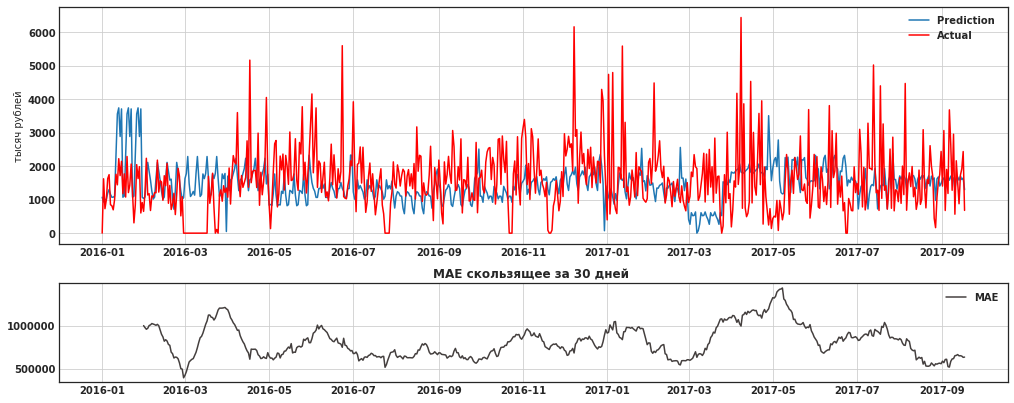

In [17]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),add_features_table=events,auto_lags=False)
y, yhat,_ = pred.predict(timeseries=play)
results = pd.DataFrame({'факт': y, 'прогноз':yhat})
plot_double(results['прогноз'],results['факт'])

In [18]:
mae = round(np.nanmean(np.abs(results['факт'] - results['прогноз'])), 2)
print("MAE : {}".format(mae))

MAE : 805891.4


Что если заменить простои банкомата средним за последние 14 дней?

In [19]:
play_mean=play.copy()
for i in  play_downtime.index:
    play_mean[play_downtime.iloc[i][0]:play_downtime.iloc[i][1]]=play_mean[:play_downtime.iloc[i][0]][-15:-1].mean()

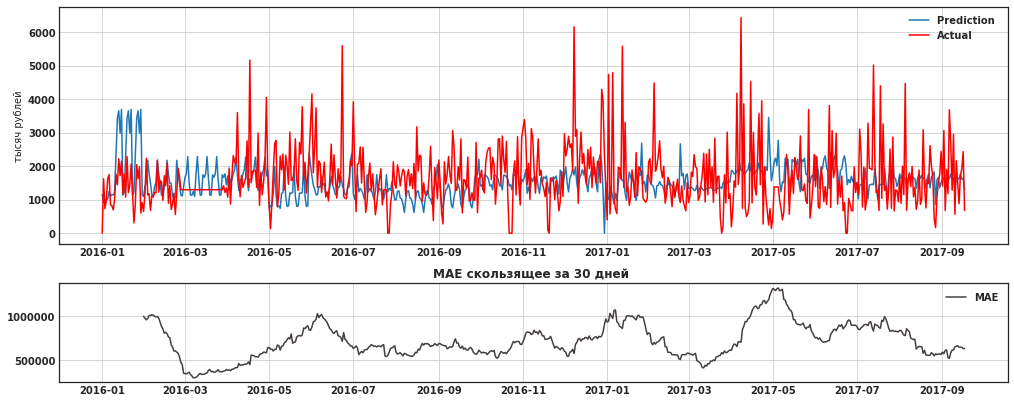

In [20]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),add_features_table=events,auto_lags=False)
y, yhat,_ = pred.predict(timeseries=play_mean)
results = pd.DataFrame({'факт': y, 'прогноз':yhat})
plot_double(results['прогноз'],results['факт'])

In [21]:
mae = round(np.nanmean(np.abs(results['факт'] - results['прогноз'])), 2)
print("MAE : {}".format(mae))

MAE : 718595.35


Попробуем более умный подход - заменять простои предсказаниями.

In [22]:
play_changed=play.copy()

In [23]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),add_features_table=events,auto_lags=False)
play_changed=play.copy()
for index in play_downtime.index:
    horizon = (play_downtime.downtime_end[index] - play_downtime.downtime_begin[index]).days + 1
    y,yhat,_ = pred.predict(timeseries=play[:play_downtime.downtime_end[index]], 
                            backward_window_size=len(play[:play_downtime.downtime_end[index]])-horizon,
                            forward_window_size=horizon) 

    play_changed[yhat.index] = yhat

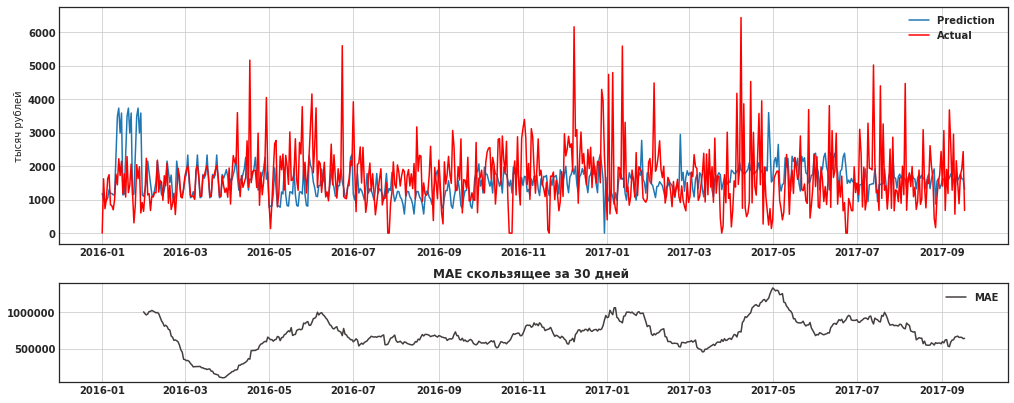

In [24]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),add_features_table=events,auto_lags=False)
y, yhat,_ = pred.predict(timeseries=play_changed)
results = pd.DataFrame({'факт': y, 'прогноз':yhat})
plot_double(results['прогноз'],results['факт'])

In [25]:
mae = round(np.nanmean(np.abs(results['факт'] - results['прогноз'])), 2)
print("MAE : {}".format(mae))

MAE : 705853.39


Ну что ж, удалось добиться увеличения качества.